## EDA VisDrone Dataset

In [ ]:
!pip3 install hvplot
!pip3 install opencv-python
!pip install seaborn

In [39]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import hvplot.pandas
import cv2
from dask import bag, diagnostics
import seaborn as sns

%matplotlib inline

In [46]:
def _process_data(path, train, replace_map):
    files_list = os.listdir(path)
    df = []
    for f in files_list:
        temp_df = pd.read_csv(f'{path}/{f}', header=None)
        temp_df['image_nm'] = f.split('.')[0]
        df.append(temp_df)
    df = pd.concat(df, ignore_index=True)
    if train:
        df.drop(labels=8, axis=1, inplace=True)
    df.columns = ['bbox_left', 'bbox_top', 'bbox_width', 'bbox_height', 'score', 'object_category', 'truncation', 'occlusion', 'image_nm']
    df['object_category'] = df['object_category'].map(replace_map)
    return df

In [52]:
def _get_dims(file):
    img = cv2.imread(file)
    h, w = img.shape[:2]
    return h,w

def process_img(path):
    annotation_list = os.listdir(path)
    annotation_list = [f'{path}/{x}' for x in annotation_list]
    dimsbag = bag.from_sequence(annotation_list).map(_get_dims)
    with diagnostics.ProgressBar():
        dims = dimsbag.compute()
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    return dim_df, annotation_list

In [5]:
replace_map = {0: 'ignored regions', 1: 'pedestrian', 2: 'people', 3: 'bicycle', 4: 'car',
           5: 'van', 6: 'truck', 7: 'tricycle', 8: 'awning-tricycle', 9: 'bus', 10: 'motor', 11: 'others'}

## Training and Validation

Parse the dataset

In [68]:
train_df = _process_data('../data/vis_drone_data/VisDrone2019-DET-train/annotations', True, replace_map)
val_df = _process_data('../data/vis_drone_data/VisDrone2019-DET-val/annotations', False, replace_map)

In [24]:
len(train_df['object_category'].unique()), len(val_df['object_category'].unique())

(12, 12)

Class distribution

In [70]:
train_class_df = train_df['object_category'].value_counts(normalize=True).reset_index()
val_class_df = val_df['object_category'].value_counts(normalize=True).reset_index()
train_class_df['data_type'] = 'training'
val_class_df['data_type'] = 'validation'
combine_df = pd.concat([train_class_df, val_class_df])

In [71]:
combine_df

,index,object_category,data_type
0,car,0.409750,training
1,pedestrian,0.224401,training
2,motor,0.083855,training
3,people,0.076535,training
4,van,0.070587,training
5,truck,0.036416,training
6,bicycle,0.029642,training
7,ignored regions,0.024927,training
8,bus,0.016761,training
9,tricycle,0.013611,training


Text(0.5, 1.0, 'Distribution of Class By Data Type')

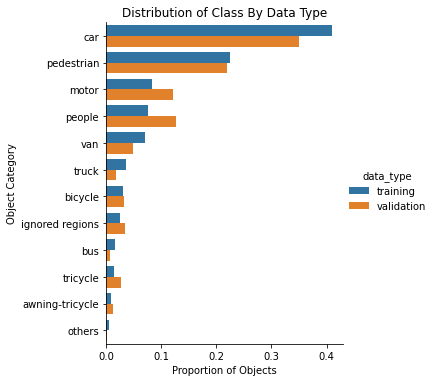

In [72]:
sns.catplot(y = "index", x ="object_category", hue="data_type", data=combine_df, kind="bar")
plt.xlabel('Proportion of Objects')
plt.ylabel('Object Category')
plt.title(f'Distribution of Class By Data Type')

Image dims

In [53]:
train_dim_df, train_annotation_list = process_img('../data/vis_drone_data/VisDrone2019-DET-train/images')
val_dim_df, val_annotation_list = process_img('../data/vis_drone_data/VisDrone2019-DET-val/images')

[########################################] | 100% Completed | 27.1s


In [58]:
len(train_annotation_list), len(val_annotation_list)

(6471, 548)

In [59]:
train_sizes = train_dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
train_sizes['data_type'] = 'training'
val_sizes = val_dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
val_sizes['data_type'] = 'validation'
combine_sizes = pd.concat([train_sizes, val_sizes])

In [63]:
combine_sizes

,height,width,count,data_type
0,360,480,1,training
1,540,960,250,training
2,756,1344,1,training
3,765,1360,743,training
4,788,1400,1299,training
5,1042,1389,1,training
6,1048,1398,30,training
7,1050,1400,2498,training
8,1078,1916,537,training
9,1080,1920,339,training


In [66]:
combine_sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1600), ylim=(0,2100), color='data_type', grid=True, xticks=5, 
        yticks=5, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0, title='Images Dimension by Data Type')

:Scatter   [height]   (width,data_type,count)

Image Dims

In [ ]:
test_dim_df, test_annotation_list = process_img('../data/vis_drone_data/VisDrone2019-DET-test-dev/images')

In [33]:
test_annotation_list = os.listdir()

In [34]:
len(test_annotation_list)

1610

In [38]:
test_sizes = test_dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

In [40]:
test_sizes

,height,width,count
0,540,960,49
1,765,1360,167
2,788,1400,933
3,1050,1400,274
4,1078,1916,151
5,1080,1920,36


In [39]:
test_sizes.hvplot.scatter(x='height', y='width', size='count', xlim=(0,1600), ylim=(0,2100), grid=True, xticks=5, 
        yticks=5, height=500, width=600).options(scaling_factor=0.1, line_alpha=1, fill_alpha=0, title='Images Dimension - Test')

:Scatter   [height]   (width,count)

### Simple stats

In [41]:
# Number of images
len(test_annotation_list) + len(val_annotation_list) + len(train_annotation_list)

8629

Number of objects excluding ignored regions and others class

In [72]:
len(train_df[~train_df['object_category'].isin(['ignored regions', 'others'])]), len(val_df[~val_df['object_category'].isin(['ignored regions', 'others'])]), len(test_df[~test_df['object_category'].isin(['ignored regions', 'others'])]),

(343205, 38759, 75102)

In [73]:
len(train_df[~train_df['object_category'].isin(['ignored regions', 'others'])]) + \
len(val_df[~val_df['object_category'].isin(['ignored regions', 'others'])]) + \
len(test_df[~test_df['object_category'].isin(['ignored regions', 'others'])])

457066

##### How many labels in each image

Training

In [76]:
train_label = train_df.groupby('image_nm').size().reset_index(name='cnt')
val_label = val_df.groupby('image_nm').size().reset_index(name='cnt')
train_label['data_type'] = 'training'
val_label['data_type'] = 'validation'
train_label['cnt'].min(), train_label['cnt'].max(), val_label['cnt'].min(), val_label['cnt'].max()

(1, 914, 1, 341)

In [77]:
combine_label = pd.concat([train_label, val_label])

In [80]:
combine_label

,image_nm,cnt,data_type
0,0000002_00005_d_0000014,88,training
1,0000002_00448_d_0000015,95,training
2,0000003_00231_d_0000016,57,training
3,0000007_04999_d_0000036,59,training
4,0000007_05499_d_0000037,62,training
...,...,...,...
543,0000364_00589_d_0000798,66,validation
544,0000364_01177_d_0000799,84,validation
545,0000364_01373_d_0000780,74,validation
546,0000364_01569_d_0000781,106,validation


In [82]:
combine_label.hvplot.hist('cnt', bins=50, xlabel='Number of category per Image', ylabel='Count of Object', title='Number of Objects per Image by Data Type', by='data_type')

:NdOverlay   [data_type]
   :Histogram   [cnt]   (cnt_count)

### How often categories appear together
* Using correlation rather than hierarchical clustering for computation efficiency

Training

In [164]:
train_df

,bbox_left,bbox_top,bbox_width,bbox_height,score,object_category,truncation,occlusion,image_nm
0,266,41,43,33,1,car,0,0,9999943_00000_d_0000051
1,243,4,41,35,1,car,0,0,9999943_00000_d_0000051
2,93,307,46,48,1,van,0,0,9999943_00000_d_0000051
3,125,307,28,33,1,van,0,1,9999943_00000_d_0000051
4,296,104,41,35,1,van,0,0,9999943_00000_d_0000051
...,...,...,...,...,...,...,...,...,...
353545,1238,517,38,20,1,motor,0,1,9999990_00000_d_0000031
353546,1251,537,39,20,1,motor,0,0,9999990_00000_d_0000031
353547,1269,562,48,19,1,motor,0,0,9999990_00000_d_0000031
353548,1246,610,85,86,1,truck,0,1,9999990_00000_d_0000031


In [165]:
train_df_corr = train_df.pivot_table(index='image_nm', columns='object_category', aggfunc='size')
train_df_corr = train_df_corr.isnull().corr()

In [168]:
train_df_corr

object_category,awning-tricycle,bicycle,bus,car,ignored regions,motor,others,pedestrian,people,tricycle,truck,van
object_category,,,,,,,,,,,,
awning-tricycle,1.000000,0.209201,-0.074825,0.067421,0.084654,0.234052,0.087969,0.135901,0.246023,0.254704,0.108320,0.080873
bicycle,0.209201,1.000000,-0.085815,0.039193,0.160579,0.404351,0.035527,0.290235,0.446982,0.319825,-0.026267,0.113022
bus,-0.074825,-0.085815,1.000000,0.143338,0.099780,-0.064223,0.077055,-0.034150,-0.057365,-0.134159,0.151313,0.154909
car,0.067421,0.039193,0.143338,1.000000,0.093673,0.134853,0.030356,-0.093611,0.008777,0.068284,0.217012,0.365839
ignored regions,0.084654,0.160579,0.099780,0.093673,1.000000,0.150837,0.091455,0.087012,0.164859,0.119715,0.080778,0.097223
motor,0.234052,0.404351,-0.064223,0.134853,0.150837,1.000000,0.076485,0.274260,0.566179,0.300349,0.071145,0.155698
others,0.087969,0.035527,0.077055,0.030356,0.091455,0.076485,1.000000,0.071553,0.081758,0.045838,0.116551,0.072473
pedestrian,0.135901,0.290235,-0.034150,-0.093611,0.087012,0.274260,0.071553,1.000000,0.299732,0.167640,-0.034352,0.084153
people,0.246023,0.446982,-0.057365,0.008777,0.164859,0.566179,0.081758,0.299732,1.000000,0.279523,0.014682,0.073158


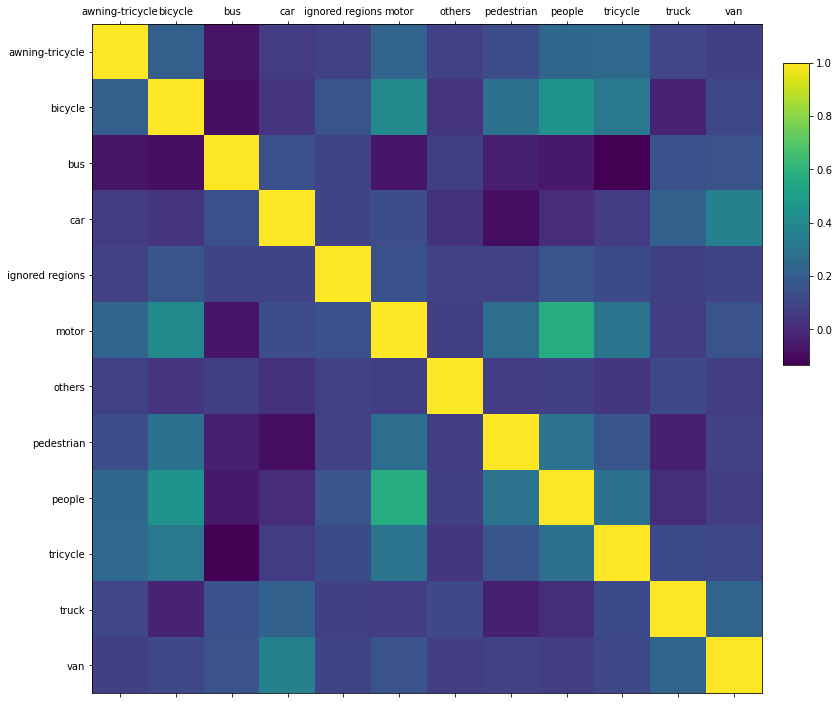

In [201]:
f = plt.figure(figsize=(12, 12))
plt.matshow(train_df_corr, fignum=f.number)
plt.xticks(range(train_df_corr.shape[0]), train_df_corr.columns, fontsize=10)
plt.yticks(range(train_df_corr.shape[0]), train_df_corr.columns, fontsize=10)
cb = plt.colorbar(cax=f.add_axes([0.95, 0.47, 0.03, 0.35]))
cb.ax.tick_params(labelsize=10)

Validation

In [150]:
val_df_corr = val_df.pivot_table(index='image_nm', columns='object_category', aggfunc='size')
val_df_corr = val_df_corr.isnull().corr()

In [153]:
val_df_corr

object_category,awning-tricycle,bicycle,bus,car,ignored regions,motor,others,pedestrian,people,tricycle,truck,van
object_category,,,,,,,,,,,,
awning-tricycle,1.000000,0.148735,0.038481,0.176017,0.180300,0.201807,0.055832,0.105511,0.211555,0.173722,0.113304,0.220433
bicycle,0.148735,1.000000,0.090465,0.063667,0.160529,0.349443,0.064504,0.273731,0.342383,0.199737,0.017889,0.177268
bus,0.038481,0.090465,1.000000,0.141880,0.288505,0.094701,0.039513,0.071767,-0.002927,0.091794,0.174745,0.186164
car,0.176017,0.063667,0.141880,1.000000,0.197183,0.077103,0.025573,-0.058740,0.000602,0.225326,0.199805,0.424526
ignored regions,0.180300,0.160529,0.288505,0.197183,1.000000,0.213230,0.000123,0.194212,0.242033,0.207972,0.165252,0.220974
motor,0.201807,0.349443,0.094701,0.077103,0.213230,1.000000,0.034087,0.306085,0.587289,0.302648,0.029535,0.195231
others,0.055832,0.064504,0.039513,0.025573,0.000123,0.034087,1.000000,0.054852,0.087471,0.086537,0.112914,0.013924
pedestrian,0.105511,0.273731,0.071767,-0.058740,0.194212,0.306085,0.054852,1.000000,0.346999,0.139979,0.026386,0.186802
people,0.211555,0.342383,-0.002927,0.000602,0.242033,0.587289,0.087471,0.346999,1.000000,0.271777,0.056500,0.155522


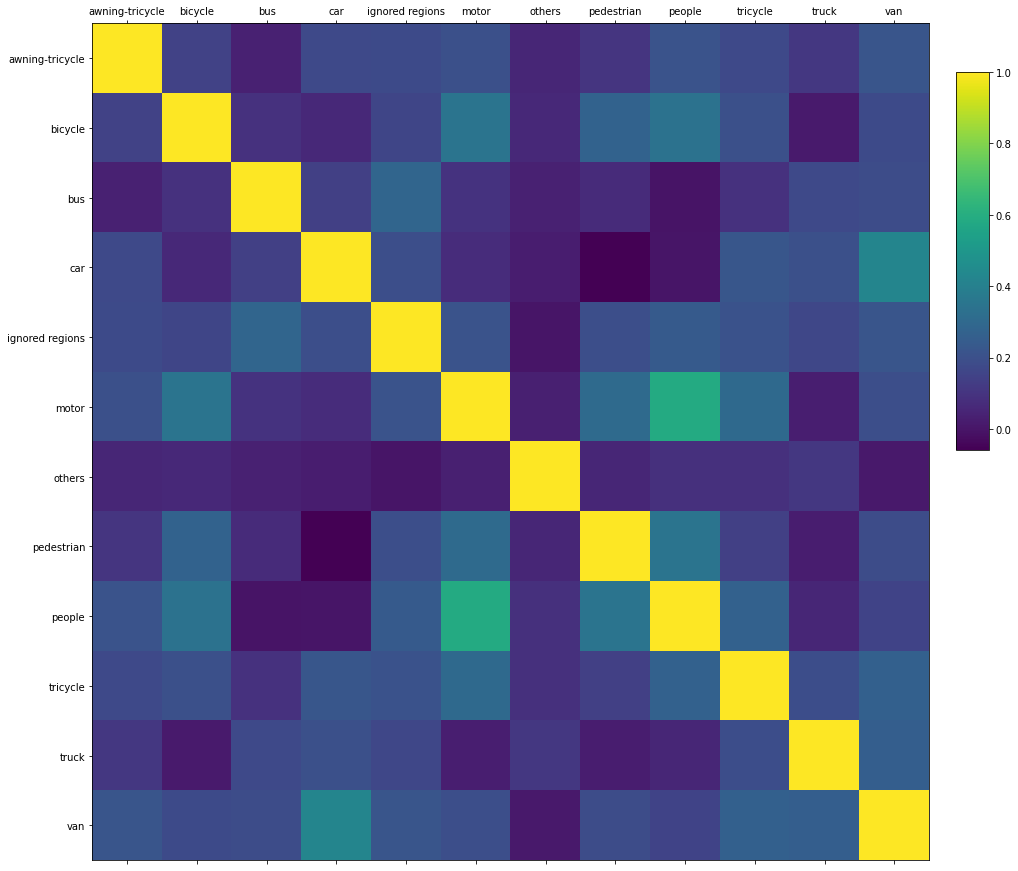

In [202]:
f = plt.figure(figsize=(15, 15))
plt.matshow(val_df_corr, fignum=f.number)
plt.xticks(range(val_df_corr.shape[0]), val_df_corr.columns, fontsize=10)
plt.yticks(range(val_df_corr.shape[0]), val_df_corr.columns, fontsize=10)
cb = plt.colorbar(cax=f.add_axes([0.95, 0.47, 0.03, 0.35]))
cb.ax.tick_params(labelsize=10)